In [1]:
import warnings
warnings.filterwarnings('ignore')
import imghdr  # 判断图片格式用的
import random
import seaborn as sns
from time import time
import paddle.fluid as fluid
import paddle
import numpy as np
from PIL import Image
import os
from multiprocessing import cpu_count
import matplotlib.pyplot as plt

In [2]:
crop_size = 300       # 剪切尺寸，最后图片的size是这个值，不是resize_size
resize_size = 320
is_color = True       # 是否加载彩色图
USE_GPU = True        # 是否使用GPU
BUF_SIZE = 528        
BATCH_SIZE = 128      # 每批次图片数量
EPOCH = 20 

## 数据预处理

In [3]:
def get_filename(filetype):
    name =[]
    final_name_list = []
    for root,dirs,files in os.walk('/home/liu/Documents/data/dogs-vs-cats-redux-kernels-edition/train'):
        for i in files:
            if filetype in i:
                name.append(i.replace(filetype,''))
    final_name_list = [filetype + item  for item in name]
    return final_name_list #返回由文件名组成的列表

In [4]:
cat_name_list = get_filename('cat')
dog_name_list = get_filename('dog')

In [5]:
def cope_file(name_list,old_path,new_path):
    for file_name in name_list:
        shutil.copyfile(os.path.join(old_path,file_name),os.path.join(new_path,file_name))#路径拼接要用os.path.join，复制指定文件到另一个文件夹里

In [6]:
old_path = '/home/liu/Documents/data/dogs-vs-cats-redux-kernels-edition/train'
data_path_cat = '/home/liu/Documents/data/dogs-vs-cats-redux-kernels-edition/Cat'
data_path_dog = '/home/liu/Documents/data/dogs-vs-cats-redux-kernels-edition/Dog'
#cope_file(cat_name_list,old_path,data_path_cat)
#cope_file(dog_name_list,old_path,data_path_dog)
data_path = [data_path_cat, data_path_dog]

In [8]:
train_img_num = 0
test_img_num  = 0
with open('./train_data.list', 'w') as f_train:
    with open('./test_data.list', 'w') as f_test:
        for label,path in enumerate(data_path):
            data_imgs = os.listdir(path)
            for i in range(0,501):
                try:
                    img_path = os.path.join(path, data_imgs[i]) # 合成路径
                    img_type = imghdr.what(img_path)            # 获取图片类型
                    if (img_type=='jpeg')|(img_type=='jpg'):    # jpeg/jpg格式图片保存
                        img_arr = np.array(Image.open(img_path))  # 获取图片数据形式
                        if len(img_arr.shape) != 2:             # 非彩色图不要
                            if i % 10 == 0:
                                test_img_num += 1
                                f_test.write(img_path + "\t" + str(label) + '\n')
                            else:
                                train_img_num += 1
                                f_train.write(img_path + "\t" + str(label) + '\n')
                except:
                    pass
print('图像列表已生成。')
print(f'训练图片{train_img_num}张，测试图片{test_img_num}张。')

图像列表已生成。
训练图片900张，测试图片102张。


## 定义读取数据
PaddlePaddle读取训练和测试数据都是通过reader来读取的，所以我们要自定义一个reader。首先我们定义一个train_mapper()函数，这个函数是对图片进行预处理的。比如通过 paddle.dataset.image.simple_transform接口对图片进行压缩然后裁剪，和灰度化，当参数is_train为True时就会随机裁剪，否则为中心裁剪，一般测试和预测都是中心裁剪。train_r()函数是从上一部分生成的图像列表中读取图片路径和标签，然后把图片路径传递给train_mapper()函数进行预处理。同样的测试数据也是相同的操作。

In [9]:
def train_mapper(sample): # 映射器
    img, label = sample
    img = paddle.dataset.image.load_image(file=img, is_color=is_color) # 加载file路径下彩色或者灰色图像
    img = paddle.dataset.image.simple_transform(im=img,
                            resize_size=resize_size, crop_size=crop_size,
                            is_color=is_color, is_train=True) # 简单的图像变换
    img = img.astype('float32') / 255.0
    return img,label
        
def train_r(train_list_path): # 这种函数里面定义函数的现象好像叫做闭包，有兴趣可以百度一下
    def reader():
        with open(train_list_path, 'r') as f:
            lines = f.readlines()
            random.shuffle(lines)              # 非常重要，对模型影响很大
            for line in lines:
                img, label = line.split('\t')  # 分离路径和标签
                yield img, int(label)          # 构建生成器
    return paddle.reader.xmap_readers(train_mapper,reader,cpu_count(),256) # 数据映射
    # xmap_readers(): 通过多线程方式，通过用户自定义的映射器mapper来映射reader返回的样本（到输出队列）。
    # 映射我清楚什么意思，但是我猜可能是从保存图像路径的集合中加载出每个路径对应的经过简单变化的图像数据
    # mapper（callable） - 一种映射reader数据的函数。
    # reader（callable） - 产生数据的reader。
    # process_num（int） - 用于处理样本的线程数目。
    # buffer_size（int） - 存有待读取数据的队列的大小。
    # 个人理解：reader返回的是图像的路径以及标签的生成器，对这些返回值经过train_mapper函数映射出图像数据

def test_mapper(sample): # sample估计就是reader返回的img，label
    img, label = sample
    img = paddle.dataset.image.load_image(file=img, is_color=is_color)
    img = paddle.dataset.image.simple_transform(im=img,
                            resize_size=resize_size, crop_size=crop_size,
                            is_color=is_color, is_train=False)
    img = img.astype('float32') / 255.0
    return img, label
    
def test_r(test_list_path):
    def reader():
        with open(test_list_path, 'r') as f:
            lines = f.readlines()
            random.shuffle(lines)
            for line in lines:
                img, label = line.split('\t')
                yield img, int(label)
    return paddle.reader.xmap_readers(test_mapper, reader, cpu_count(), 256)

## 定义卷积神经网络

In [10]:
def cnn(ipt):
    
    # 第一个卷积-池化层
    conv_pool_1 = fluid.nets.simple_img_conv_pool(
        input=ipt,         # 输入图像
        filter_size=5,     # 滤波器的大小
        num_filters=20,    # filter 的数量。它与输出的通道相同
        pool_size=2,       # 池化核大小2*2
        pool_stride=2,     # 池化步长
        act="relu")        # 激活类型
    conv_pool_1 = fluid.layers.batch_norm(conv_pool_1)
    # 第二个卷积-池化层
    conv_pool_2 = fluid.nets.simple_img_conv_pool(
        input=conv_pool_1,
        filter_size=5,
        num_filters=50,
        pool_size=2,
        pool_stride=2,
        act="relu")
    conv_pool_2 = fluid.layers.batch_norm(conv_pool_2)
    # 第三个卷积-池化层
    conv_pool_3 = fluid.nets.simple_img_conv_pool(
        input=conv_pool_2,
        filter_size=5,
        num_filters=50,
        pool_size=2,
        pool_stride=2,
        act="relu")
    # 以softmax为激活函数的全连接输出层，10类数据输出10个数字
    prediction = fluid.layers.fc(input=conv_pool_3, size=2, act='softmax')

    return prediction

## 获取网络

通过上面定义的卷积神经网络获取一个分类器，网络的输入层是通过fluid.layers.data()接口定义的，例如输入的形状为[1,128,128]，表示单通道，宽度和高度都是28的图。

In [11]:
c = 3 if is_color else 1
image = fluid.layers.data(name='image', shape=[c,crop_size,crop_size], dtype='float32')
net = cnn(image)

## 定义损失函数

使用交叉熵函数，fluid.layers.cross_entropy，还是用了fluid.layers.accuracy接口，方便在训练和测试时输出平均值。

In [12]:
label = fluid.layers.data(name='label', shape=[1], dtype='int64') # 训练数据标签
cost = fluid.layers.cross_entropy(input=net, label=label) # 传入网络和对应标签,一个batch的损失值
avg_cost = fluid.layers.mean(cost)    # 对一个batch的损失值求得平均值
acc = fluid.layers.accuracy(input=net, label=label)

## 克隆测试程序
在定义损失之后和定义优化方法之前从主程序中克隆一个测试程序

In [13]:
test_program = fluid.default_main_program().clone(for_test=True)

## 定义优化方法
使用Adam优化方法

In [14]:
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)
opt = optimizer.minimize(avg_cost) # 通过优化方法不断使avg_cost尽量小

## 创建执行器

In [15]:
place = fluid.core.CPUPlace()# 使用CPU执行训练
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

## 把图片生成reader
把上面定义的reader按照设置的大小得到每一个batch的reader

In [16]:
train_reader = paddle.batch( # 此操作创建一个分批读取器，该成批读取器将输入读取器中的数据组合到成批数据中。
                             # 多以说train_reader是一个读取器
                            reader=paddle.reader.shuffle(  # 创建一个经过装饰的读取器
                                    reader=train_r('./train_data.list'),
                                    buf_size=BUF_SIZE),
                            batch_size=BATCH_SIZE) # 训练数据每BATCH_SIZE张照片为一个批次
test_reader = paddle.batch(
                            reader=paddle.reader.shuffle(
                                    reader=test_r('./test_data.list'),
                                    buf_size=BUF_SIZE),
                            batch_size=BATCH_SIZE)

## 定义输入数据的维度
第一个是图片数据，第二个是标签

In [17]:
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

开始训练
在每一个Pass训练完之后都用测试集数据测试一下模型准确率

In [18]:
training_costs = []
training_accs =  []
testing_costs  = []
testing_accs  =  []

In [19]:
start = time()
for pass_id in range(1,EPOCH+1):
    train_costs, train_accs = [], []
    for batch_id, data in enumerate(train_reader()):
        train_cost, train_acc = exe.run(
                    program=fluid.default_main_program(),
                    feed=feeder.feed(data),
                    fetch_list=[avg_cost, acc])
        train_costs.append(train_cost)
        train_accs.append(train_acc)
        training_costs.append(train_cost)
        training_accs.append(train_acc)
    train_cost = sum(train_costs) / len(train_costs)
    train_acc  = sum(train_accs)  / len(train_accs)
    # print("Pass:%d\tTrain_cost:%.5f\tAccuracy:%.5f" % (pass_id, train_cost, train_acc)) # 每批次结束时输出
    
    test_costs, test_accs = [], []
    for batch_id, data in enumerate(test_reader()):
        test_cost, test_acc = exe.run(
                    program=test_program,
                    feed=feeder.feed(data),
                    fetch_list=[avg_cost, acc])
        test_costs.append(test_cost)
        test_accs.append(test_acc)
        testing_costs.append(test_cost)
        testing_accs.append(test_acc)
    test_cost = sum(test_costs) / len(test_costs)
    test_acc  = sum(test_accs)  / len(test_accs)
    
    print("\nPass:%d \tTrain_cost:%.5f\tTrain_acc:%.5f\tTest_cost:%.5f\tTest_acc:%.5f\n"
            %(pass_id,train_cost,train_acc,test_cost,test_acc))
end = time()


Pass:1 	Train_cost:9.00283	Train_acc:0.52930	Test_cost:1.41355	Test_acc:0.51961


Pass:2 	Train_cost:2.63573	Train_acc:0.53516	Test_cost:5.67986	Test_acc:0.49020


Pass:3 	Train_cost:3.45871	Train_acc:0.54883	Test_cost:0.99112	Test_acc:0.52941


Pass:4 	Train_cost:1.35620	Train_acc:0.57422	Test_cost:1.65391	Test_acc:0.52941


Pass:5 	Train_cost:1.62590	Train_acc:0.60742	Test_cost:1.11975	Test_acc:0.61765


Pass:6 	Train_cost:1.30487	Train_acc:0.55762	Test_cost:1.59629	Test_acc:0.53922


Pass:7 	Train_cost:1.40241	Train_acc:0.62695	Test_cost:1.57475	Test_acc:0.56863


Pass:8 	Train_cost:1.33171	Train_acc:0.58594	Test_cost:0.75495	Test_acc:0.63725


Pass:9 	Train_cost:0.85805	Train_acc:0.61719	Test_cost:0.71997	Test_acc:0.68627


Pass:10 	Train_cost:1.11736	Train_acc:0.58105	Test_cost:1.29550	Test_acc:0.52941


Pass:11 	Train_cost:1.15793	Train_acc:0.53906	Test_cost:0.90145	Test_acc:0.66667


Pass:12 	Train_cost:1.08473	Train_acc:0.49609	Test_cost:2.19192	Test_acc:0.50980


Pass:13 	Tra

In [20]:
print(f"用时{end-start}s")

用时3421.0365109443665s


In [21]:
training_costs = [x[0] for x in training_costs]
training_accs = [x[0] for x in training_accs]
testing_costs = [x[0] for x in testing_costs]
testing_accs = [x[0] for x in testing_accs]

<AxesSubplot:title={'center':'test_acc'}>

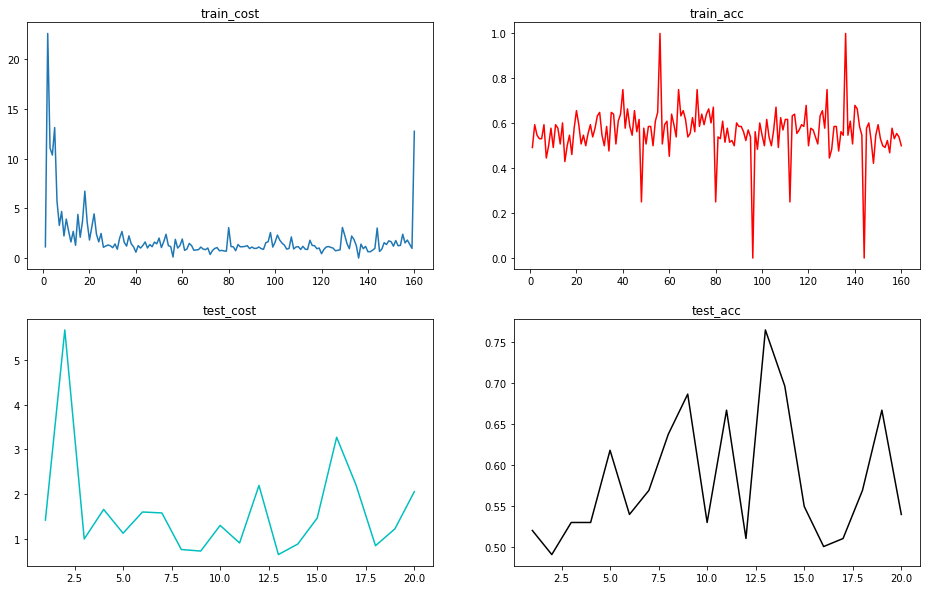

In [22]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.title('train_cost')
sns.lineplot(x=list(range(1,1+len(training_costs))),y=training_costs)
plt.subplot(222)
plt.title('train_acc')
sns.lineplot(x=list(range(1,1+len(training_accs))),y=training_accs,color='r')
plt.subplot(223)
plt.title('test_cost')
sns.lineplot(x=list(range(1,1+len(testing_costs))),y=testing_costs,color='c')
plt.subplot(224)
plt.title('test_acc')
sns.lineplot(x=list(range(1,1+len(testing_accs))),y=testing_accs,color='k')

In [23]:
save_model_dir = "/home/liu/Documents/data/dogs-vs-cats-redux-kernels-edition/model/Cat&Dog"
if not os.path.exists(save_model_dir):
    os.makedirs(save_model_dir)
print(f"Saved model to {save_model_dir}")

# 保存模型到指定目录
fluid.io.save_inference_model(dirname=save_model_dir,
                              feeded_var_names=['image'], # 字符串列表，预测期间需要喂入的数据变量名称
                              target_vars=[net],          # 变量列表，从net中我们可以得到推理结果
                             executor=exe)                # 保存模型的推理程序

Saved model to /home/liu/Documents/data/dogs-vs-cats-redux-kernels-edition/model/Cat&Dog


['save_infer_model/scale_0.tmp_0']

## 加载模型并预测

In [24]:
# 构建测试用的执行器
infer_exe = fluid.Executor(place)
# 指定作用域
inference_scope = fluid.core.Scope()

In [25]:
with fluid.scope_guard(scope=inference_scope):
    # load model
    [inference_program,     # 预测程序
     feed_target_names,     # 需要在推理时提供的数据名称 字符串列表
     fetch_targets] = fluid.io.load_inference_model(  # 从fetch_traget中可以得到预测结果 变量列表
                      dirname=save_model_dir, executor=infer_exe)
    infer_reader = paddle.batch(reader=paddle.reader.shuffle(
                                                    reader=test_r('./test_data.list'),
                                                    buf_size=BUF_SIZE),
                                batch_size=BATCH_SIZE)
    all_result = [] # 保存测试结果
    test_y = []     # 保存真实标签
    for data in infer_reader():
        test_x = np.array([x[0] for x in data]).astype("float32") # 提取图片数据
        test_y.append([x[1] for x in data])   # 提取图片标签
        result = infer_exe.run(program=inference_program,
                               feed={feed_target_names[0]:test_x},
                               fetch_list=fetch_targets)
        all_result.append(result[0])

In [26]:
# 整理预测结果和真实标签成一维numpy.ndarray
infer_lab = np.array([np.argmax(x) for batch in all_result for x in batch]).astype("int32")
true_lab = np.array([x for batch in test_y for x in batch]).astype("int32")

In [27]:
print(f"预测准确率为：{sum(infer_lab==true_lab)/len(true_lab)}")

预测准确率为：0.5392156862745098
